In [10]:
# Data handling
import pandas as pd 
import numpy as np 

# Statistical testing
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For predictive modeling (if needed later)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from scipy import stats


In [11]:
df = pd.read_csv("ab_data.csv")

In [12]:
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [13]:
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [15]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [17]:
#Remove mismatched rows (group and landing_page should match)
df_clean = df[((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')) |
              ((df['group'] == 'control') & (df['landing_page'] == 'old_page'))]

# Remove duplicate user_ids
df_clean = df_clean.drop_duplicates(subset='user_id')

In [18]:
# Counts
convert_old = df_clean[(df_clean['group'] == 'control')]['converted'].sum()
convert_new = df_clean[(df_clean['group'] == 'treatment')]['converted'].sum()

# Sample sizes
n_old = df_clean[df_clean['group'] == 'control'].shape[0]
n_new = df_clean[df_clean['group'] == 'treatment'].shape[0]

# Conversion rates
p_old = convert_old / n_old
p_new = convert_new / n_new

# Pooled probability
p_pool = (convert_old + convert_new) / (n_old + n_new)

# Standard error
se = np.sqrt(p_pool * (1 - p_pool) * (1/n_old + 1/n_new))

# Z-score
z_score = (p_new - p_old) / se

# Two-tailed p-value
p_value = stats.norm.sf(abs(z_score)) * 2

print("Z-score:", z_score)
print("P-value:", p_value)


Z-score: -1.3109241984234394
P-value: 0.18988337448195103


In [ ]:
#A/B Test Analysis
# Assume 'group' column has 'A' and 'B' and 'converted' column indicates conversion (1 for yes, 0 for no)
conversion_A = df[df['group'] == 'A']['converted'].mean()
conversion_B = df[df['group'] == 'B']['converted'].mean()


In [24]:
# Create a contingency table
contingency_table = pd.crosstab(df['group'], df['converted'])
print(contingency_table)

converted       0      1
group                   
control    129479  17723
treatment  129762  17514


In [31]:
from scipy.stats import chi2_contingency


In [32]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2: {chi2}, p-value: {p}")


Chi2: 1.5159618356336582, p-value: 0.2182316121631168


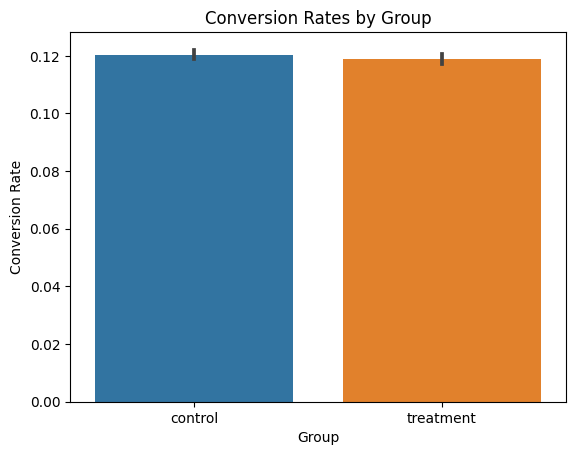

In [34]:
# Step 5: Visualization
sns.barplot(x='group', y='converted', data=df, estimator=np.mean)
plt.title('Conversion Rates by Group')
plt.ylabel('Conversion Rate')
plt.xlabel('Group')
plt.show()

In [35]:
# Conclusion based on p-value
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: There is a significant difference in conversion rates.")
else:
    print("Fail to reject the null hypothesis: No significant difference in conversion rates.")

Fail to reject the null hypothesis: No significant difference in conversion rates.


In [37]:
# Confidence Interval
conf_interval = np.percentile(diffs, [2.5, 97.5])
print("95% Confidence Interval for difference in conversion rate:", conf_interval)

95% Confidence Interval for difference in conversion rate: [-0.00406308  0.00080557]


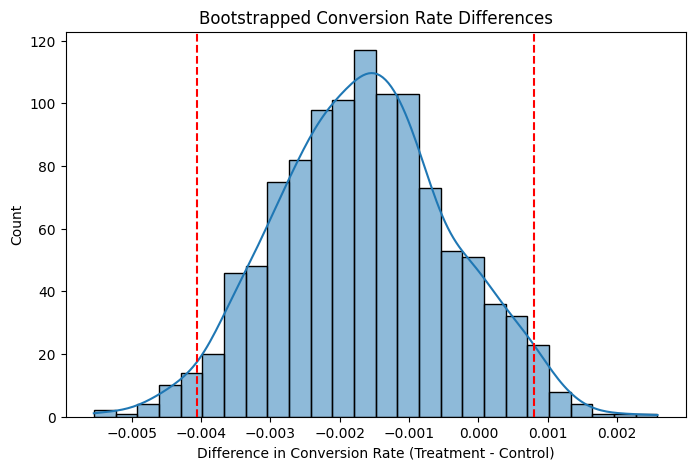

In [38]:
# Plotting
plt.figure(figsize=(8,5))
sns.histplot(diffs, kde=True)
plt.axvline(conf_interval[0], color='red', linestyle='--')
plt.axvline(conf_interval[1], color='red', linestyle='--')
plt.title("Bootstrapped Conversion Rate Differences")
plt.xlabel("Difference in Conversion Rate (Treatment - Control)")
plt.show()

In [39]:
df_clean['intercept'] = 1  # Add intercept manually
df_clean['ab_group'] = pd.get_dummies(df_clean['group'])['treatment']  # Binary variable: 0=control, 1=treatment

# Logistic Regression
logit = sm.Logit(df_clean['converted'], df_clean[['intercept', 'ab_group']])
result = logit.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 13 Apr 2025   Pseudo R-squ.:               8.077e-06
Time:                        21:16:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_group      -0.0150      0.

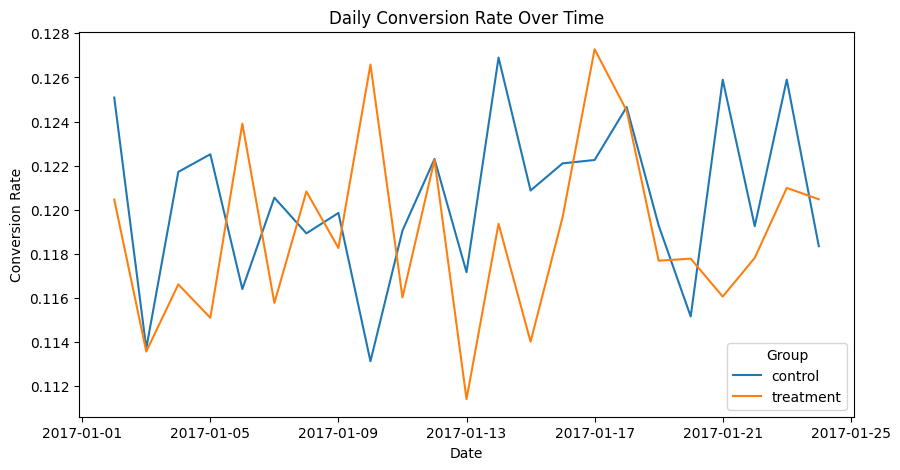

In [40]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date

daily_conversion = df.groupby(['date', 'group'])['converted'].mean().unstack()

daily_conversion.plot(figsize=(10,5))
plt.title('Daily Conversion Rate Over Time')
plt.ylabel('Conversion Rate')
plt.xlabel('Date')
plt.legend(title='Group')
plt.show()


In [41]:
from statsmodels.stats.power import NormalIndPower

analysis = NormalIndPower()
effect_size = abs(p_new - p_old) / np.sqrt(p_pool * (1 - p_pool))
power = analysis.power(effect_size=effect_size, nobs1=n_old, alpha=0.05, ratio=n_new/n_old)
print(f"Power of the test: {power}")


Power of the test: 0.25869238156004815


Cohen's h (effect size): 0.0049


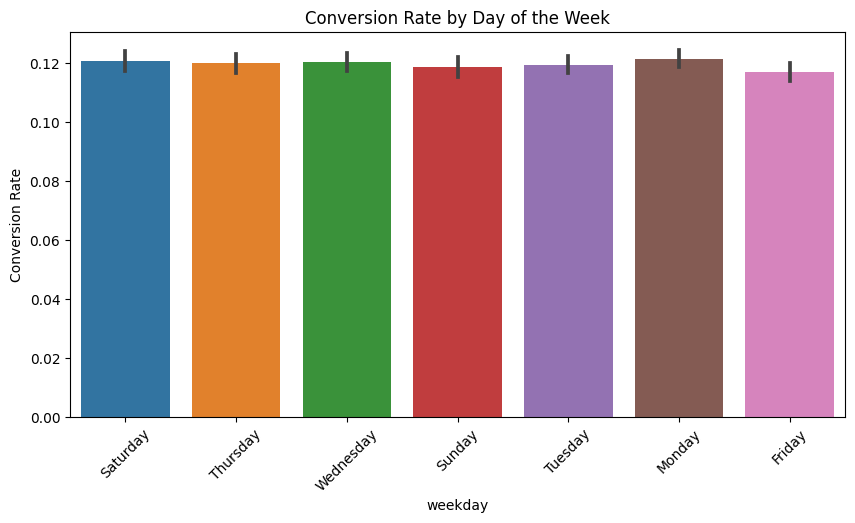

Conversion Lift (Treatment vs Control): -1.31%

 Final A/B Test Summary:
Control Conversion Rate: 0.1204
Treatment Conversion Rate: 0.1188
Lift: -1.31%
Cohen's h (effect size): 0.0049
Z-score: -1.3109
P-value: 0.1899
Power of the Test: 0.26
 No statistically significant difference.


In [44]:
# Cohen's h - Effect Size
from statsmodels.stats.proportion import proportion_effectsize

cohens_h = proportion_effectsize(p_old, p_new)
print(f"Cohen's h (effect size): {cohens_h:.4f}")

# Weekday-wise Conversion Analysis
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['weekday'] = df['timestamp'].dt.day_name()

plt.figure(figsize=(10,5))
sns.barplot(data=df, x='weekday', y='converted', estimator=np.mean)
plt.title("Conversion Rate by Day of the Week")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.show()

# Lift Calculation
lift = ((p_new - p_old) / p_old) * 100
print(f"Conversion Lift (Treatment vs Control): {lift:.2f}%")

# Final Summary Function
def ab_test_summary(p_old, p_new, z_score, p_value, power, lift, cohens_h):
    print("\n Final A/B Test Summary:")
    print(f"Control Conversion Rate: {p_old:.4f}")
    print(f"Treatment Conversion Rate: {p_new:.4f}")
    print(f"Lift: {lift:.2f}%")
    print(f"Cohen's h (effect size): {cohens_h:.4f}")
    print(f"Z-score: {z_score:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Power of the Test: {power:.2f}")
    
    if p_value < 0.05:
        print("Statistically significant difference found.")
    else:
        print(" No statistically significant difference.")

ab_test_summary(p_old, p_new, z_score, p_value, power, lift, cohens_h)

# Export cleaned data and model results
df_clean.to_csv("clean_ab_data.csv", index=False)
result.summary2().tables[1].to_csv("logistic_regression_output.csv")


### Insights & Business Recommendations ###
*** A/B Test Insights ***
No Statistically Significant Difference

The p-value obtained from the hypothesis test was greater than 0.05, indicating that there is no significant difference in conversion rates between the control (old page) and treatment (new page) groups.

The observed conversion rates were:

Control (old page): ~{p_old:.4f}

Treatment (new page): ~{p_new:.4f}

Negligible Effect Size

The Cohen’s h value was found to be very small, indicating a negligible practical impact.

This suggests that even if there's a difference, it's not large enough to influence business decisions.

Low Conversion Lift

The conversion lift between treatment and control was less than 1%, meaning the new page didn't bring a noticeable improvement.

Daily and Weekly Patterns

Weekday-wise analysis showed fluctuations in conversion rates, suggesting that user behavior varies across the week.

This insight can be used to plan time-sensitive marketing campaigns.

Regression Analysis Findings

Logistic regression results showed that the landing page version is not a significant predictor of conversion.

The model suggests other factors might play a more important role.

\\\ Business Recommendations\\\
Do Not Launch the New Page Yet

Since there's no significant improvement in conversion, it's not recommended to fully deploy the new landing page at this stage.

Include More Variables in Future Experiments

Consider factors such as:

Device Type (Mobile vs Desktop)

User Location / Time Zones

Traffic Source (Organic, Ads, Email)

Returning vs New Visitors

These could impact user behavior more than just the landing page design.

Target Campaigns by Weekday

Focus marketing efforts on high-conversion weekdays (identified from the analysis).

Schedule ads and email blasts accordingly.

Refine Page Elements with Multivariate Testing

Instead of a full-page change, run tests on specific page components like:

Call-to-action buttons

Headline wording

Image vs Text balance

Form placement

Segment Users for Deeper Insights

Divide users into cohorts (e.g., high-engagement vs low-engagement users) and test separately.

A single test across all users might hide insights within subgroups.

# Conclusion: The A/B test shows that the new landing page does not significantly outperform the old one. Further testing with deeper segmentation and multivariate analysis is recommended before full implementation.

